# Data analysis 
(New Replacement)

<br>
Qidu Fu
<br>
3/14/2025
<br>
<br>

**Contents**
- [0 Load data](#0-load-data)
- [1 Data code-switching](#1-detect-code-switching)
    - [1.1 Experiment with regex](#11-experiment-with-regex)
    - [1.2 Experiment with langdetect](#12-experiment-with-the-library-langdetect)
    - [1.3 Experiment with langid](#13-experiment-with-the-library-langid)
    - [1.4 Apply code-switching detection](#14-apply-code-switching-detection)
- [2 Conduct topic modeling](#2-conduct-topic-modeling-to-aggregatecluster-the-topics)
    - [2.1 Use K-Means](#21-use-k-means)
    - [2.2 Use LDA](#22-use-lda)
    - [2.3 Use WordCloud](#23-use-wordcloud-to-visualize-the-clusters)
    - [2.4 Apply topic modeling](#24-apply-topic-modeling-assign-topics)
- [3 Analyze the topic distribution](#3-analyze-the-topic-distribution-exploratory-analysis)

## 0 Load data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

RANDOM_STATE = 100

In [2]:
STACK_DF = pd.read_csv('private/stack_exchange_cleaned.csv')
STACK_DF.head()

,text,topic
0,My translation of Li Bai's 《三五七言》,"translation, poetry"
1,What do these characters on an antique mural p...,"character identification, traditional characte..."
2,Help in translating Li Bai's 《月下独酌·其二》,"translation, poetry"
3,purpose of using 了 with 要不,grammar
4,Why does the character 的 is pronounced differe...,"pronunciation, songs"


In [3]:
STACK_DF.sample(20)

,text,topic
10498,"不得不, 必须, 只好, 应该: what's the difference?","word choice, mandarin"
4467,How do current Mandarin speakers usually prono...,pronunciation
1289,Why 雨下了 is not used?,usage
5120,"What is the function of ""根本"" in 这杯咖啡根本不值得花四十元人民币?","grammar, vocabulary"
816,"How do you express a ""generous grader""?",word choice
2267,What does 多一些 mean?,meaning in context
11776,How do I type the lü for Character Romanization?,"pinyin, input methods"
4714,Does the word '县子‘ exist？,"word choice, usage"
10806,What would be the shortest translation for 'Ho...,"translation, usage"
10895,is google correct translate for me?,"translation, simplified characters"


In [4]:
STACK_DF.iloc[160, ]

text     Chinese bronze dagger inscriptions
topic      meaning, characters, calligraphy
Name: 160, dtype: object

In [5]:
sample_idx = np.random.choice(STACK_DF.index, 25, replace=False)
STACK_DF.loc[sample_idx, 'text']

5596                 Is zai4 + ... + li3 really a mistake?
6681              Is it a solvable Idiom Crossword Puzzle?
11307    How to wish people good health, etc during Chi...
11364                    Correct way to say "each person"?
2664                                      Slogan “澀得起，就係我”
10061                    How to make a tenseless sentence?
11769             How would you translate 细腻 into English?
744                    How should I understand 不要说“你应该……”?
839                                     Glyph origin of 咒?
2535     Why do the Chinese characters on my phone and ...
8723                 Ordering take-out in Taiwan 带走 vs 外帶?
4542           How and when is 做 used as the verb "to be"?
4594     How should I say "I feel very good/I'm very fi...
7974                                  N and NG in Mandarin
2842               How to use “ 难道 ” in Chinese sentences?
5466     As verbs, what’s the difference between 经历 and...
4678                      Meaning of 滾水 as Cantonese idi

## 1 Detect code-switching
- Using regex to detect code-switching sentences, which produce to consistent results, through human checking (the author) of a 300-records of sample data
- However, using langdetect, the library, does not produce accuracy results; therefore, it is not  used. 
- Similar to langdetect, langid does not produce accurate results; therefore, it is not used. These libraries work well with long text; however, the posts are short. This may explain the reason.
- Apply the regex to detect the CS. 

### 1.1 Experiment with regex

In [6]:
def detect_code_switching_regex(text):
    """
    Detects code-switching between Chinese and English in the provided text.
    
    Parameters:
    text (str): The input text in which code-switching is to be detected.
    
    Returns:
    bool: True if both Chinese characters and English letters are found in the text, 
            False otherwise.
    """
    contains_chinese = bool(re.search(r'[\u4e00-\u9fff]', text))
    contains_english = bool(re.search(r'[a-zA-Z]', text))
    return contains_chinese and contains_english

STACK_DF.loc[sample_idx, 'text'].apply(detect_code_switching_regex)

5596     False
6681     False
11307     True
11364    False
2664      True
10061    False
11769     True
744       True
839       True
2535     False
8723      True
4542      True
4594      True
7974     False
2842      True
5466      True
4678      True
9514     False
11029     True
8553      True
7876      True
10262     True
11876     True
5052      True
1016     False
Name: text, dtype: bool

### 1.2 Experiment with the library langdetect 

In [7]:
# Install langdetect
# !pip3 install langdetect

In [8]:
from langdetect import detect_langs

def detect_code_switching_langdetect(text):
    """
    Detects code-switching between Chinese and English in the provided text using the langdetect library.
    
    Parameters:
    text (str): The input text in which code-switching is to be detected.
    
    Returns:
    bool: True if both Chinese ('zh-cn') and English ('en') are detected in the text, False otherwise.
    """
    try:
        # Detect languages in the text
        langs = detect_langs(text)
        # Extract language codes
        lang_codes = [lang.lang for lang in langs]
        # Check if both Chinese and English are present
        return 'zh-cn' in lang_codes and 'en' in lang_codes
    except Exception as e:
        # Return False if an error occurs (e.g., invalid text format)
        return False

print('abd 我爱你: ', detect_code_switching_langdetect('abd 我爱你'))
STACK_DF.loc[sample_idx, 'text'].apply(detect_code_switching_langdetect)

abd 我爱你:  False


5596     False
6681     False
11307    False
11364    False
2664     False
10061    False
11769    False
744      False
839      False
2535     False
8723     False
4542     False
4594     False
7974     False
2842     False
5466     False
4678     False
9514     False
11029    False
8553     False
7876     False
10262    False
11876    False
5052     False
1016     False
Name: text, dtype: bool

### 1.3 Experiment with the library: langid

In [9]:
# Install library
# !pip3 install langid


In [10]:
import langid

def detect_code_switching_langid(text):
    """
    Detects code-switching between Chinese and English in the provided text using langid.
    
    Parameters:
    text (str): The input text in which code-switching is to be detected.
    
    Returns:
    bool: True if both Chinese ('zh') and English ('en') are detected in the text, False otherwise.
    """
    try:
        # Classify the text to detect language
        detected_languages = langid.classify(text)  # returns a tuple: (language_code, probability)
        detected_lang_code = detected_languages[0]

        # Check if both Chinese and English are detected
        if 'zh' in detected_lang_code and 'en' in detected_lang_code:
            return True
        else:
            return False
    except Exception as e:
        # Return False if an error occurs
        return False

# Apply the function to your DataFrame
STACK_DF.loc[sample_idx, 'text'].apply(detect_code_switching_langid)


5596     False
6681     False
11307    False
11364    False
2664     False
10061    False
11769    False
744      False
839      False
2535     False
8723     False
4542     False
4594     False
7974     False
2842     False
5466     False
4678     False
9514     False
11029    False
8553     False
7876     False
10262    False
11876    False
5052     False
1016     False
Name: text, dtype: bool

### 1.4 Apply code-switching detection

In [11]:
STACK_DF['code_switching'] = STACK_DF['text'].apply(detect_code_switching_regex)
STACK_DF.sample(10)

,text,topic,code_switching
1712,Meaning of 才 in 这样 才 更 容易 获得 幸福,adverbs,True
10233,"Mices and rats: differences between shǔ, lǎo s...",translation,False
8138,Alternative expression for 二位小姐,"grammar, phrase",True
7264,"Is 看怎麼理解? a generalized expression for ""it dep...","translation, grammar, mandarin, cantonese",True
10556,What would 黑著臉 mean?,translation,True
9586,Is Chinese really that ambigous in oral commun...,"pinyin, phonology, ambiguity",False
2312,How many Cantonese speakers who don't speak Ma...,"mandarin, cantonese, topolect",False
1947,Tool for processing Chinese text,"pinyin, traditional vs simplified, software",False
3183,"When should I use ""了"" in “把”字句 and where shoul...",grammar,True
2870,What does 乐助 (yuè zhù) mean?,meaning,True


In [12]:
# Rearrange the columns
STACK_DF = STACK_DF[['text', 'code_switching', 'topic']]
STACK_DF.head()

,text,code_switching,topic
0,My translation of Li Bai's 《三五七言》,True,"translation, poetry"
1,What do these characters on an antique mural p...,False,"character identification, traditional characte..."
2,Help in translating Li Bai's 《月下独酌·其二》,True,"translation, poetry"
3,purpose of using 了 with 要不,True,grammar
4,Why does the character 的 is pronounced differe...,True,"pronunciation, songs"


## 2. Conduct topic modeling to aggregate/cluster the topics
As mentioned in the previous Jupyter Notebook, the original topics were more than 3000 using value counts. Therefore, further aggregation/clustering is needed. 
Based on the K-Means and LDA (and wordcloud), I interpreted and categorized the text into the following six categories/topics/domains (according to LDA):
0) speech (e.g., pronunciation, Pinyin, and other)
1) translation - meaning
2) character - meaning
3) grammar
4) character identification
5) vocabulary (e.g., word choice)


### 2.1 Use K-Means

- Based on KMeans' inertia plot, 6 clusters may be used.

In [13]:
STACK_DF.topic.value_counts()

translation                                                            974
grammar                                                                601
meaning                                                                464
meaning in context                                                     238
word choice                                                            217
                                                                      ... 
terms of address, formal                                                 1
meaning in context, etymology, character identification                  1
idioms, colloquialisms                                                   1
character identification, traditional characters, seal, old chinese      1
translation, style                                                       1
Name: topic, Length: 3502, dtype: int64

In [14]:
# Use Kmeans clustering to find the optimal number of clusters
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

def topic_model_kmeans(vectorizer, n_clusters=5):
    """
    Creates a KMeans clustering model pipeline using a given vectorizer.

    Parameters:
    vectorizer (object): A vectorizer (e.g., TfidfVectorizer) to be used in the pipeline.
    n_clusters (int): The number of clusters to form. Default is 5.

    Returns:
    pipeline: A scikit-learn pipeline with the provided vectorizer and KMeans model.
    """
    kmeans = KMeans(n_clusters=n_clusters)
    # Create a pipeline with the provided vectorizer and KMeans model
    pipeline = make_pipeline(vectorizer, kmeans)
    return pipeline

In [15]:
def plot_inertia(STACK_DF, pipeline, max_clusters=10, random_state=RANDOM_STATE):
    """
    Plots the inertia for different numbers of clusters to help identify the optimal number.

    Parameters:
    STACK_DF (DataFrame): The input DataFrame containing text data in the 'topic' column.
    pipeline (object): A scikit-learn pipeline to be used for fitting the data.
    max_clusters (int): The maximum number of clusters to test. Default is 10.

    Returns:
    None: This function only generates and displays a plot of inertia values.
    """
    inertia = []  # List to store inertia values
    
    # Loop through different numbers of clusters
    for n in range(1, max_clusters + 1):
        # Update the pipeline with the current number of clusters
        pipeline.set_params(kmeans__n_clusters=n, 
                                kmeans__random_state=random_state)
        
        # Fit the pipeline to the data
        pipeline.fit(STACK_DF['topic'])
        
        # Get the KMeans model from the pipeline
        kmeans = pipeline.named_steps['kmeans']
        
        # Append the inertia value for the current model
        inertia.append(kmeans.inertia_)
    
    # Plot inertia to visualize the optimal number of clusters
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('KMeans Inertia')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

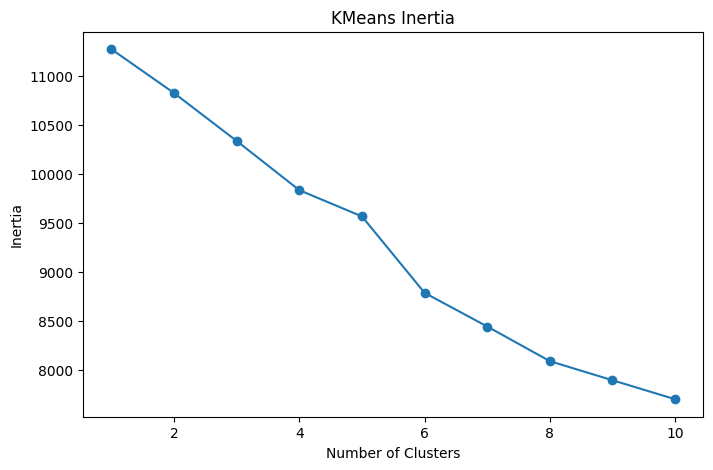

In [16]:
import nltk
# Define a vectorizer
vectorizer = TfidfVectorizer(max_features=10000, stop_words=None, 
                                ngram_range=(1, 2), 
                                tokenizer=nltk.word_tokenize,
                                token_pattern=None)

# Create a pipeline with the vectorizer
kmeans_pipeline = topic_model_kmeans(vectorizer)

# Test with a random sample from your DataFrame
# sample_idx = np.random.choice(STACK_DF.index, 300, replace=False)
plot_inertia(STACK_DF, kmeans_pipeline, max_clusters=10)

In [17]:
# Retrain the model with the optimal number of clusters: 6
kmeans_pipeline.set_params(kmeans__n_clusters=6, 
                            kmeans__random_state=RANDOM_STATE)
kmeans_pipeline.fit(STACK_DF['topic'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 token_pattern=None,
                                 tokenizer=<function word_tokenize at 0x30b558820>)),
                ('kmeans', KMeans(n_clusters=6, random_state=100))])

In [18]:
def get_top_keywords(pipeline, n_terms=10):
    """
    Extracts the top keywords for each cluster in a KMeans model.
    
    Parameters:
    pipeline (Pipeline): A trained scikit-learn pipeline containing a TfidfVectorizer and KMeans model.
    n_terms (int): The number of top words to extract per cluster.
    
    Returns:
    DataFrame: A DataFrame showing the top keywords for each cluster.
    """
    # Extract the vectorizer and KMeans model from the pipeline
    vectorizer = pipeline.named_steps['tfidfvectorizer']
    kmeans = pipeline.named_steps['kmeans']
    
    # Get feature names (words) from the TF-IDF vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Identify the top words for each cluster
    top_keywords = []
    for cluster in range(kmeans.n_clusters):
        # Get indices of top TF-IDF words in the cluster centroid
        top_indices = kmeans.cluster_centers_[cluster].argsort()[-n_terms:][::-1]
        top_words = feature_names[top_indices]
        top_keywords.append(top_words)
    
    # Create a DataFrame for better visualization
    topic_df = pd.DataFrame(top_keywords, index=[f"Cluster {i}" for i in range(kmeans.n_clusters)], columns=[f"Word {i+1}" for i in range(n_terms)])
    
    return topic_df

# Run the function to get top words per cluster
kmeans_top_words_df = get_top_keywords(kmeans_pipeline, n_terms=10)
kmeans_top_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Cluster 0,",",word,difference,word choice,choice,vocabulary,usage,etymology,"translation ,",", word"
Cluster 1,meaning,meaning in,context,in,in context,", meaning",",","context ,","translation ,","meaning ,"
Cluster 2,identification,character identification,character,", character","identification ,",",",", seal",seal,"translation ,",translation
Cluster 3,grammar,"grammar ,",",",", grammar","translation ,",", usage",usage,translation,", sentence",", particles"
Cluster 4,characters,"characters ,",",",simplified,simplified characters,traditional,", characters",traditional characters,", simplified",", traditional"
Cluster 5,translation,art,", 了",abbreviations,academic,"academic ,",accent,address,"address ,",adjectives


### 2.2 Use LDA
Based on KMeans, 6 topics may be good. Therefore, 6 topics are used in the LDA model training.

In [19]:
# Use LDA for topic modeling
from sklearn.decomposition import LatentDirichletAllocation

def topic_model_lda(vectorizer, n_topics=5, random_state=RANDOM_STATE):
    """
    Creates an LDA topic modeling pipeline using a given vectorizer.

    Parameters:
    vectorizer (object): A vectorizer (e.g., TfidfVectorizer) to be used in the pipeline.
    n_topics (int): The number of topics to generate. Default is 5.

    Returns:
    pipeline: A scikit-learn pipeline with the provided vectorizer and LDA model.
    """
    lda = LatentDirichletAllocation(n_components=n_topics, 
                                        random_state=random_state)
    # Create a pipeline with the provided vectorizer and LDA model
    pipeline = make_pipeline(vectorizer, lda)
    return pipeline

lda_pipeline = topic_model_lda(vectorizer, n_topics=6)
lda_pipeline

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 token_pattern=None,
                                 tokenizer=<function word_tokenize at 0x30b558820>)),
                ('latentdirichletallocation',
                 LatentDirichletAllocation(n_components=6, random_state=100))])

In [20]:
# Evaluate the LDA model
def get_and_display_topics(model, feature_names, n_top_words=10):
    """
    Displays the top words for each topic in an LDA model and returns a DataFrame.

    Parameters:
    model (object): A trained LDA model.
    feature_names (list): A list of words obtained from the vectorizer's get_feature_names() method.
    n_top_words (int): The number of top words to display for each topic. Default is 10.

    Returns:
    DataFrame: A DataFrame containing the top words for each topic.
    """
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(top_words)
        message = f"Topic {topic_idx}: " + " ".join(top_words)
        print(message)
    
    # Create a DataFrame with the top words for each topic
    topics_df = pd.DataFrame(topics, columns=[f'Word {i+1}' for i in range(n_top_words)])
    return topics_df

# Fit the LDA model to the data
lda_pipeline.fit(STACK_DF.loc[sample_idx, 'topic'])

# Get the LDA model from the pipeline
lda_model = lda_pipeline.named_steps['latentdirichletallocation']

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the top words for each topic and display them
lda_top_words_df = get_and_display_topics(lda_model, feature_names, n_top_words=10)

# Display the DataFrame with the top words for each topic
# print(lda_top_words_df)


Topic 0: grammar , adjectives mandarin adjectives mandarin , translation , , , translation translation meaning
Topic 1: , structure sentence sentence structure grammar , grammar , sentence choice choice , word choice
Topic 2: pronunciation characters , , word word idioms , , puzzle puzzle idioms grammar ,
Topic 3: meaning phrase meaning phrase , context in in context meaning in characters , glyph
Topic 4: expressions translation difference , idioms cantonese cantonese , idioms , grammar meaning
Topic 5: meaning , translation grammar characters expressions word idioms context in


### 2.3 Use WordCloud to visualize the clusters

In [21]:
# Install wordcloud
# !pip3 install wordcloud

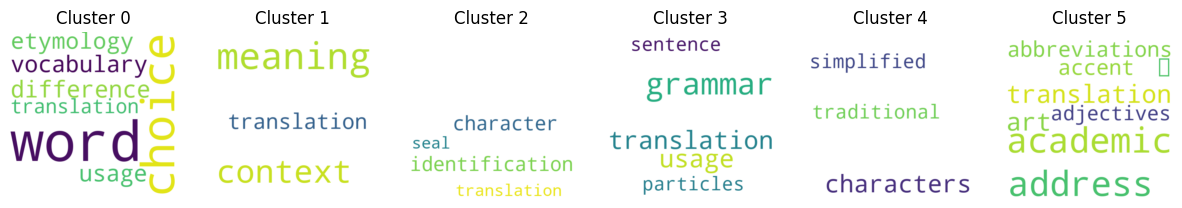

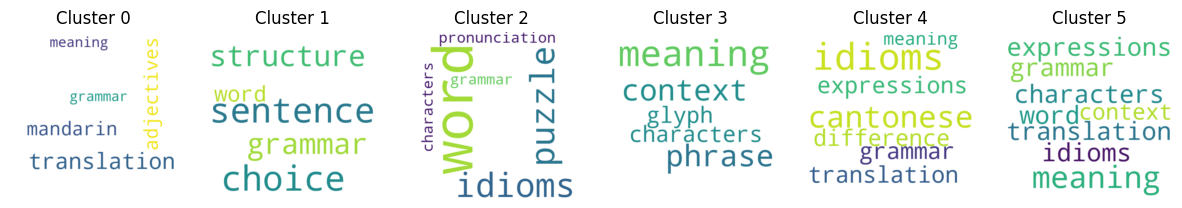

In [22]:
from wordcloud import WordCloud

def plot_wordclouds(top_words_df):
    """
    Generates a word cloud for each cluster.
    
    Parameters:
    top_words_df (DataFrame): DataFrame containing top keywords per cluster.
    
    Returns:
    None: Displays word clouds for each cluster.
    """
    fig, axes = plt.subplots(1, len(top_words_df), figsize=(15, 5))
    
    for i, (cluster, words) in enumerate(top_words_df.iterrows()):
        text = " ".join(words)
        wordcloud = WordCloud(width=500, height=500, background_color="white").generate(text)
        
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].axis("off")
        axes[i].set_title(f"Cluster {i}")
    
    plt.show()

# Generate and display word clouds
plot_wordclouds(kmeans_top_words_df)
plot_wordclouds(lda_top_words_df)


In [23]:
print('Kmeans top words: ------------------------------------')
kmeans_top_words_df

Kmeans top words: ------------------------------------


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Cluster 0,",",word,difference,word choice,choice,vocabulary,usage,etymology,"translation ,",", word"
Cluster 1,meaning,meaning in,context,in,in context,", meaning",",","context ,","translation ,","meaning ,"
Cluster 2,identification,character identification,character,", character","identification ,",",",", seal",seal,"translation ,",translation
Cluster 3,grammar,"grammar ,",",",", grammar","translation ,",", usage",usage,translation,", sentence",", particles"
Cluster 4,characters,"characters ,",",",simplified,simplified characters,traditional,", characters",traditional characters,", simplified",", traditional"
Cluster 5,translation,art,", 了",abbreviations,academic,"academic ,",accent,address,"address ,",adjectives


In [24]:
print('LDA top words: ------------------------------------')
lda_top_words_df

LDA top words: ------------------------------------


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
0,grammar,", adjectives",mandarin,adjectives,"mandarin ,","translation ,",",",", translation",translation,meaning
1,",",structure,sentence,sentence structure,"grammar ,",grammar,", sentence",choice,"choice ,",word choice
2,pronunciation,characters,",",", word",word,"idioms ,",", puzzle",puzzle,idioms,"grammar ,"
3,meaning,phrase meaning,phrase,",",context,in,in context,meaning in,"characters ,",glyph
4,expressions,translation,difference,", idioms",cantonese,"cantonese ,",idioms,",",grammar,meaning
5,meaning,",",translation,grammar,characters,expressions,word,idioms,context,in


### 2.4 Apply topic modeling: assign topics

In [25]:
# Use the LDA model and assign topics to the entire dataset
# 0) speech (e.g., pronunciation, Pinyin, and other)
# 1) translation - meaning
# 2) character - meaning
# 3) grammar
# 4) character identification
# 5) vocabulary (e.g., word choice)
STACK_DF['topic_idx'] = lda_pipeline.transform(STACK_DF['topic']).argmax(axis=1)
# Map the topic numbers to the topic names
topic_map = {
    0: 'speech',
    1: 'translation',
    2: 'character',
    3: 'grammar',
    4: 'character identification',
    5: 'vocabulary'
}
STACK_DF['topic_lda'] = STACK_DF['topic_idx'].map(topic_map)
STACK_DF.sample(10)

,text,code_switching,topic,topic_idx,topic_lda
7167,"""Everywhere"" as 到处都 or 到处都是",True,"grammar, meaning in context",3,grammar
3389,Chinese Idiom puzzle 18 (中文填字遊戲),True,"idioms, games, puzzle",2,character
1411,What is 冎's history and its relation to 骨 and 剮?,True,"characters, glyph origin",3,grammar
4225,"How did 所以 semantically shift from ""what one u...",True,etymology,0,speech
1660,Please explain the sentence structure of 高高的举起...,True,"grammar, sentence",1,translation
10603,Difference Between 加 and 添,True,difference,4,character identification
10282,Resources for the Chinese section of the Gaokao?,False,"writing, learning, culture, mainland china, ac...",1,translation
11915,Should the temporal indicators be in a certain...,False,sentence structure,1,translation
7674,"What does ""你吃了吗?"" mean?",True,"translation, slang",0,speech
11260,"How to say, ""Did you hold your cellphone close...",False,"cantonese, topolect",4,character identification


## 3 Analyze the topic distribution: exploratory analysis

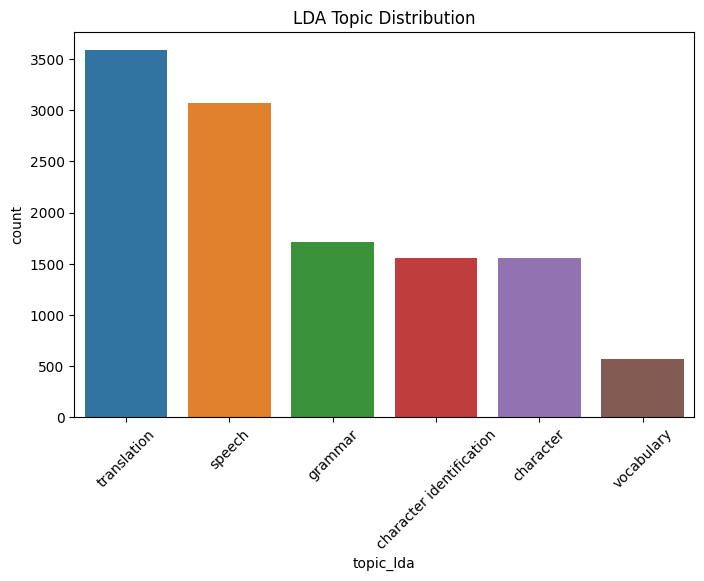

In [26]:
# Display the distribution of topics
def plot_topic_distribution(df, topic_col, title):
    """
    Plots the distribution of topics in a DataFrame.
    
    Parameters:
    df (DataFrame): The input DataFrame containing the topics.
    topic_col (str): The column name containing the topics.
    title (str): The title of the plot.
    
    Returns:
    None: This function displays a plot.
    """
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=topic_col, 
                    order=df[topic_col].value_counts().index)
    # Rotate x-labels for better readability
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

plot_topic_distribution(STACK_DF, 'topic_lda', 'LDA Topic Distribution')

In [27]:
# save the dataframe to a new csv file
STACK_DF.to_csv('private/stack_exchange_topics.csv', index=False)
print('df is saved to stack_exchange_topics.csv')

df is saved to stack_exchange_topics.csv
